# Week 2: Supervised Techniques for Regression
## Boston Housing Assignment

 Scikit Learn documentation for this assignment:
 http://scikit-learn.org/stable/modules/model_evaluation.html 
 http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
 http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
 http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
 http://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

 
 Textbook reference materials:
 Geron, A. 2017. Hands-On Machine Learning with Scikit-Learn
 and TensorFlow. Sebastopal, Calif.: O'Reilly. Chapter 3 Training Models
 has sections covering linear regression, polynomial regression,
 and regularized linear models. Sample code from the book is 
 available on GitHub at https://github.com/ageron/handson-ml


## Requirements for this assignment

    1) Use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study.
    2) Use one of two response variables: (1) the median value of homes in thousands of 1970 dollars or (2) the log median value of homes in thousands of 1970 dollars. 
    3) Employ at least two regression modeling methods selected from those discussed in Chapter 4 of the Géron (2017) textbook: linear regression, ridge regression, lasso regression, and elastic net.
    4) Evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. 


Python scikit-learn should be your primary environment for conducting this research. Note that it is not necessary to employ polynomial regression in this assignment.

## Management problem:

Imagine that you are advising a real estate brokerage firm in its attempt to employ machine learning methods. The firm wants to use machine learning to complement conventional methods for assessing the market value of residential real estate. Of the modeling methods examined in your study, which would you recommend to management, and why?

# A: Libraries and data read-in

In [1]:
RANDOM_SEED = 1

# although we standardize X and y variables on input,
# we will fit the intercept term in the models
# Expect fitted values to be close to zero
SET_FIT_INTERCEPT = True

# import base packages into the namespace for this program
import numpy as np
import pandas as pd
from math import sqrt  # for root mean-squared error calculation

#diplay and plotting
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm

#import from SKlearn
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import sklearn.metrics as metrics

from scipy import stats

# read data for the Boston Housing Study
boston_input = pd.read_csv("C:/Users/bblank/Documents/Northwestern MSDS/datasets/boston.csv")

In [2]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

    #coefs = np.append(lm.intercept_,lm.coef_)

def model_statistics(x_actual, y_actual, y_predict, coefs):

    matX = pd.DataFrame({"Constant":np.ones(len(x_actual))}).join(pd.DataFrame(x_actual.reset_index(drop=True)))
    MSE = (sum((y_actual-y_predict)**2))/(len(matX)-len(matX.columns))
    

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.inv(np.dot(matX.T,matX)).diagonal())
    
    sd_b = np.sqrt(var_b)
    ts_b = coefs/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(matX)-len(matX.columns)-1))) for i in ts_b]
    

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    coefs = np.round(coefs,4)

    SummaryDF = pd.DataFrame()
    SummaryDF["Coefficients"],SummaryDF["Standard Errors"],SummaryDF["t values"],SummaryDF["Probabilities"] = [coefs,sd_b,ts_b,p_values]

    return(SummaryDF)

# B: Descriptive Stats and Dataframe inspect

In [3]:
# check the pandas DataFrame object boston_input
print('\nboston DataFrame (first and last five rows):')
display(boston_input.head())
display(boston_input.tail())

print('\n\nGeneral description of the boston_input DataFrame:\n')
display(boston_input.info())

# drop neighborhood from the data being considered
boston = boston_input.drop('neighborhood', 1)
print('\n\nGeneral description of the boston DataFrame:\n')

display(boston.info())

print('\nDescriptive statistics of the boston DataFrame:\n')
display(boston.describe())


boston DataFrame (first and last five rows):


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
0,Nahant,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,Swampscott,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,Swanpscott,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,Marblehead,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,Marblehead,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


,neighborhood,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
501,Winthrop,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,Winthrop,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,Winthrop,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,Winthrop,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0
505,Winthrop,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,7.88,19.0




General description of the boston_input DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   neighborhood  506 non-null    object 
 1   crim          506 non-null    float64
 2   zn            506 non-null    float64
 3   indus         506 non-null    float64
 4   chas          506 non-null    int64  
 5   nox           506 non-null    float64
 6   rooms         506 non-null    float64
 7   age           506 non-null    float64
 8   dis           506 non-null    float64
 9   rad           506 non-null    int64  
 10  tax           506 non-null    int64  
 11  ptratio       506 non-null    float64
 12  lstat         506 non-null    float64
 13  mv            506 non-null    float64
dtypes: float64(10), int64(3), object(1)
memory usage: 55.5+ KB


None



General description of the boston DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rooms    506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  mv       506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


None


Descriptive statistics of the boston DataFrame:



,crim,zn,indus,chas,nox,rooms,age,dis,rad,tax,ptratio,lstat,mv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.528854
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.182176
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


array([[<AxesSubplot:title={'center':'crim'}>,
        <AxesSubplot:title={'center':'zn'}>,
        <AxesSubplot:title={'center':'indus'}>,
        <AxesSubplot:title={'center':'chas'}>],
       [<AxesSubplot:title={'center':'nox'}>,
        <AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'dis'}>],
       [<AxesSubplot:title={'center':'rad'}>,
        <AxesSubplot:title={'center':'tax'}>,
        <AxesSubplot:title={'center':'ptratio'}>,
        <AxesSubplot:title={'center':'lstat'}>],
       [<AxesSubplot:title={'center':'mv'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

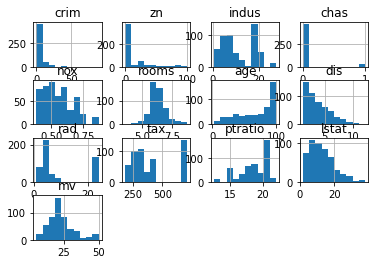

In [4]:
boston.hist()

## Correlation Heatmap

Text(0.5, 0.98, 'Correlation Heatmap for Boston')

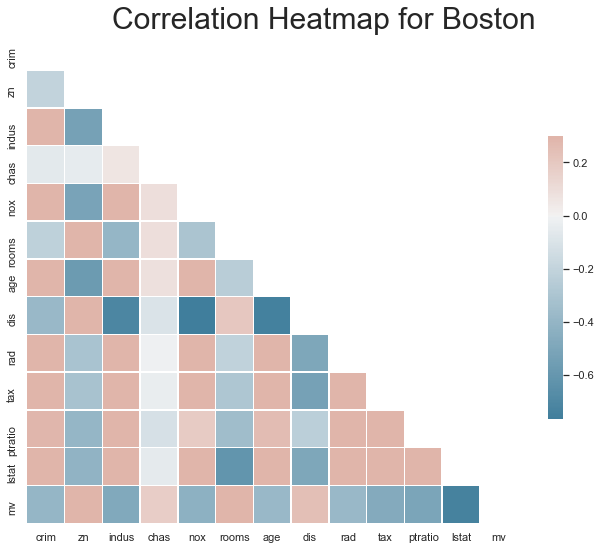

In [5]:
sns.set_theme(style="white")

#correlation matrix
corr =boston.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.subplots_adjust(top=1)
plt.suptitle("Correlation Heatmap for Boston",fontsize= 30)


<AxesSubplot:xlabel='ptratio', ylabel='tax'>

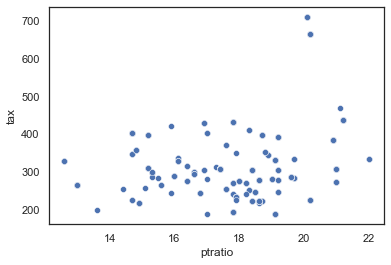

In [6]:
sns.scatterplot(boston.ptratio, boston.tax)

<AxesSubplot:xlabel='tax', ylabel='mv'>

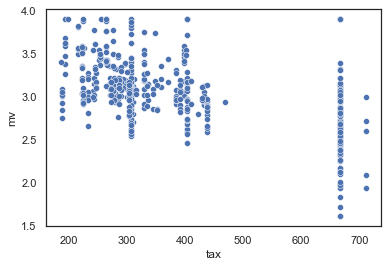

In [7]:
sns.scatterplot(boston.tax, np.log(boston.mv))

#This looks like there's going to be little gained here due to the cluster of tax > 600 being spread across all median values

<AxesSubplot:>

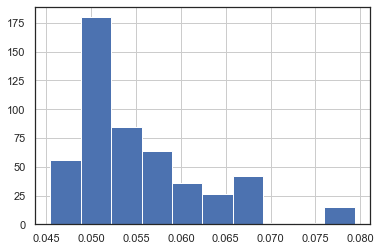

In [8]:
inv_ratio= 1/boston.ptratio
inv_ratio.hist()


<AxesSubplot:>

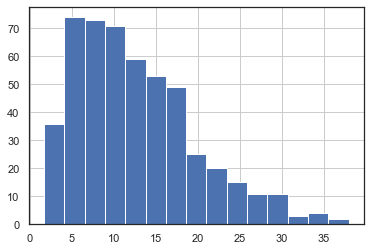

In [9]:
boston.lstat.hist(bins=15)

<AxesSubplot:>

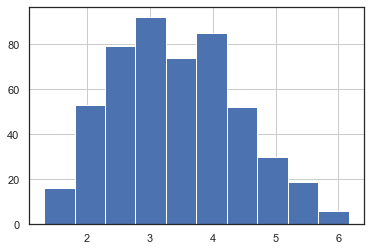

In [10]:
log = np.sqrt(boston.lstat)

log.hist()



<AxesSubplot:>

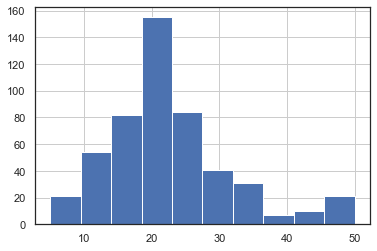

In [11]:
boston.mv.hist()

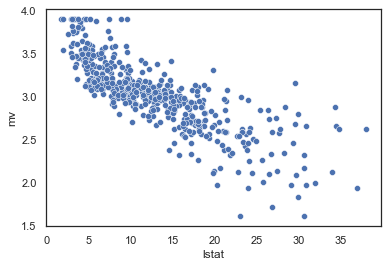

In [12]:
logplot = sns.scatterplot(y=np.log(boston.mv), x=boston.lstat)



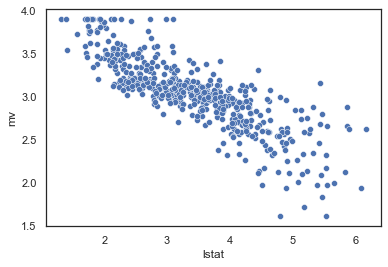

In [13]:
sqrtfeatureplot = sns.scatterplot(y=np.log(boston.mv), x= np.sqrt(boston.lstat))

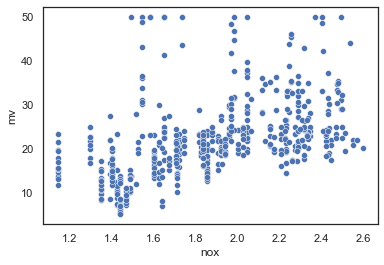

In [14]:
sqrtfeatureplot = sns.scatterplot(y=boston.mv, x= 1/boston.nox)


# C: Data Scaling and Preparation

In [15]:
boston_trimmed = boston[['mv', 'nox', 'lstat', 'ptratio']]

boston_trimmed['inv_nox'] = 1/boston_trimmed['nox']
boston_trimmed['sqrt_lstat'] = np.sqrt(boston_trimmed['lstat'])
boston_trimmed['log_MV']= np.log(boston_trimmed['mv'])
boston_trimmed['inv_ptratio'] = 1/boston_trimmed['ptratio']



model_data =boston_trimmed[['log_MV','sqrt_lstat']]



StandardScaler()


<AxesSubplot:xlabel='sqrt_lstat', ylabel='log_MV'>

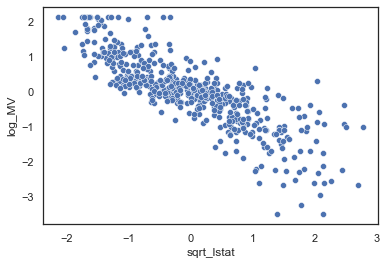

In [16]:

scaler = StandardScaler()
print(scaler.fit(model_data))
# show standardization constants being employed
#print(scaler.mean_)
#print(scaler.scale_)

# the model data will be standardized form of preliminary model data
scaled_df = pd.DataFrame(scaler.fit_transform(model_data), columns= ['log_MV', 'sqrt_lstat'])

sns.scatterplot(data=scaled_df, x='sqrt_lstat', y='log_MV')

## Summary of what we now have
    1) scaled_df contains the scaled values for our model using standard scaler
    2) model_data contains unscaled model data.



## Create Train and Test ; prep for modeling by separating dependant and independant variables.

In [17]:
# splits both scaled and unscaled data in same random state.
ScaledTrain_set, ScaledTest_set = train_test_split(scaled_df, test_size = 0.2, random_state = 12)

Train_set, Test_set = train_test_split(model_data, test_size = 0.2, random_state = 12)


#separate features from labels for scaled data
ScaledTrain_Labels = ScaledTrain_set['log_MV'].copy()
ScaledTest_Labels = ScaledTest_set['log_MV'].copy()
ScaledTrain_Features = ScaledTrain_set.drop('log_MV', axis=1)
ScaledTest_Features = ScaledTest_set.drop('log_MV', axis=1)

#separate features from labels for non scaled data
Train_Labels = Train_set['log_MV'].copy()
Test_Labels = Test_set['log_MV'].copy()

Train_Features = Train_set.drop('log_MV', axis=1)
Test_Features = Test_set.drop('log_MV', axis=1)




# D: Regression Choices

## 1. LinearRegression 

### 1a) Non-scaled data

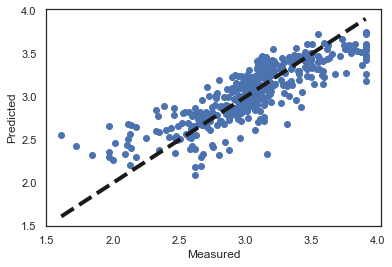

In [18]:
L_regress = LinearRegression()
L_regress.fit(Train_Features,Train_Labels)

Train_Labels_pred = L_regress.predict(Train_Features)

fig, train = plt.subplots()
train.scatter(Train_Labels, Train_Labels_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
train.plot([Train_Labels.min(), Train_Labels.max()], [Train_Labels.min(), Train_Labels.max()], 'k--', lw=4)
train.set_xlabel('Measured')
train.set_ylabel('Predicted')

plt.show()

In [19]:
regression_results(Train_Labels,Train_Labels_pred)

explained_variance:  0.685
mean_squared_log_error:  0.0036
r2:  0.685
MAE:  0.1772
MSE:  0.0529
RMSE:  0.2301


### Getting some summary statistics
    1) Including inv_ptratio in model with sqrt_lstat and inv_nox yielded a non significant pvalue for inv_ptratio (p-value ~ 0.912); removed and re-ran the model
    2) after removing inv_ptratio, pvalue for inv_nox is also non-significant (p-value ~ 0.872)
    3) final model coefficients below for log(MV) = m*sqrt(lstat) + b
### We can decrease the RMSE by ~ 10% of the value by includeing the two additional terms, but this adds complexity to the model and as such our model may not generalize very well. There is a chance for overfitting the training data if these terms are included.


In [20]:
coefs = np.append(L_regress.intercept_,L_regress.coef_)

model_statistics(x_actual=Train_Features, y_actual=Train_Labels, y_predict=Train_Labels_pred, coefs=coefs)

,Coefficients,Standard Errors,t values,Probabilities
0,4.2136,0.041,102.455,0.0
1,-0.3446,0.012,-29.570,0.0


### 1b) Scaled Data
    Scaling the data looks like it produces the same statistics

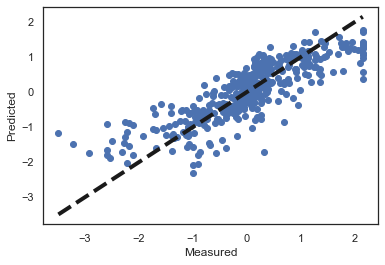

In [21]:
Std_L_regress = LinearRegression()
Std_L_regress.fit(ScaledTrain_Features,ScaledTrain_Labels)

Std_Train_Labels_pred = Std_L_regress.predict(ScaledTrain_Features)

fig, std_train = plt.subplots()
std_train.scatter(ScaledTrain_Labels, Std_Train_Labels_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)
std_train.plot([ScaledTrain_Labels.min(), ScaledTrain_Labels.max()], [ScaledTrain_Labels.min(), ScaledTrain_Labels.max()], 'k--', lw=4)
std_train.set_xlabel('Measured')
std_train.set_ylabel('Predicted')

plt.show()

In [22]:
regression_results(Train_Labels,Train_Labels_pred)

explained_variance:  0.685
mean_squared_log_error:  0.0036
r2:  0.685
MAE:  0.1772
MSE:  0.0529
RMSE:  0.2301


## 1c Crossvalidation Scores for scaled and non scaled data; linear regression

In [23]:
L_regress = LinearRegression()
L_regress.fit(Train_Features,Train_Labels)
kfold = KFold(n_splits=8, random_state=12)

#get the predicted log(MV) for Training Set
#Train_Labels_pred = cross_val.predict(L_regress, Train_Features, Train_Labels, cv=kfold)

cv_results = cross_val_score(L_regress, Train_Features, Train_Labels, cv=kfold)
print(cv_results)

#L_regress.fit(Train_Features, Train_Labels)


[0.55442578 0.6391653  0.73070225 0.76982723 0.72142008 0.69872271
 0.68838193 0.55385667]


In [24]:
Std_L_regress = LinearRegression()
Std_L_regress.fit(ScaledTrain_Features, ScaledTrain_Labels)

kfold = KFold(n_splits=8, random_state=12)

#get the predicted log(MV) for Training Set
#Train_Labels_pred = cross_val.predict(L_regress, Train_Features, Train_Labels, cv=kfold)

cv_results = cross_val_score(Std_L_regress, ScaledTrain_Features, ScaledTrain_Labels, cv=kfold)
print(cv_results)


[0.55442578 0.6391653  0.73070225 0.76982723 0.72142008 0.69872271
 0.68838193 0.55385667]


## 2. ElasticNet

## 2a) ElasticNet for the non scaled data

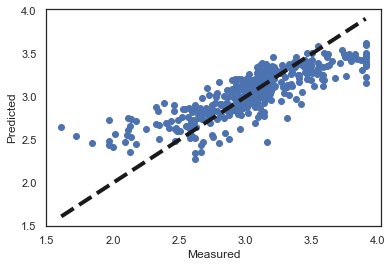

In [25]:
Elastic_regress = ElasticNet(alpha=0.1, l1_ratio= 0.5)
Elastic_regress.fit(Train_Features,Train_Labels)

EN_Train_Labels_pred = Elastic_regress.predict(Train_Features)

fig, train = plt.subplots()
train.scatter(Train_Labels, EN_Train_Labels_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)

train.set_xlabel('Measured')
train.set_ylabel('Predicted')
train.plot([Train_Labels.min(), Train_Labels.max()], [Train_Labels.min(), Train_Labels.max()], 'k--', lw=4)
plt.show()

In [26]:
regression_results(Train_Labels,EN_Train_Labels_pred)

explained_variance:  0.66
mean_squared_log_error:  0.0039
r2:  0.66
MAE:  0.1798
MSE:  0.0572
RMSE:  0.2391


## 2b) ElasticNet for scaled data

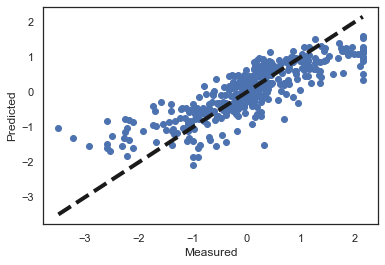

In [27]:
Std_Elastic_regress = ElasticNet(alpha=0.1, l1_ratio= 0.5)
Std_Elastic_regress.fit(ScaledTrain_Features,ScaledTrain_Labels)

EN_Std_Train_Labels_pred = Std_Elastic_regress.predict(ScaledTrain_Features)

fig, std_train = plt.subplots()
std_train.scatter(ScaledTrain_Labels, EN_Std_Train_Labels_pred)
#plt.plot(Train_Features, Train_Labels_pred, color='blue', linewidth=3)

std_train.set_xlabel('Measured')
std_train.set_ylabel('Predicted')
std_train.plot([ScaledTrain_Labels.min(), ScaledTrain_Labels.max()], [ScaledTrain_Labels.min(), ScaledTrain_Labels.max()], 'k--', lw=4)
plt.show()

In [28]:
regression_results(Train_Labels,EN_Train_Labels_pred)

explained_variance:  0.66
mean_squared_log_error:  0.0039
r2:  0.66
MAE:  0.1798
MSE:  0.0572
RMSE:  0.2391


## 2c) Cross Validation of non scaled and scaled data

In [29]:
EN_regress = ElasticNet(alpha=0.1, l1_ratio= 0.5)
EN_regress.fit(Train_Features,Train_Labels)
kfold = KFold(n_splits=8, random_state=12)

#get the predicted log(MV) for Training Set
#Train_Labels_pred = cross_val.predict(L_regress, Train_Features, Train_Labels, cv=kfold)

cv_results = cross_val_score(EN_regress, Train_Features, Train_Labels, cv=kfold)
print(cv_results)

[0.56360192 0.61902726 0.68209827 0.71885322 0.68723223 0.67430334
 0.64060891 0.59849787]


In [30]:
Std_EN_regress = ElasticNet(alpha=0.1, l1_ratio= 0.5)
Std_EN_regress.fit(ScaledTrain_Features, ScaledTrain_Labels)

kfold = KFold(n_splits=8, random_state=12)

#get the predicted log(MV) for Training Set
#Train_Labels_pred = cross_val.predict(L_regress, Train_Features, Train_Labels, cv=kfold)

cv_results = cross_val_score(Std_EN_regress, ScaledTrain_Features, ScaledTrain_Labels, cv=kfold)
print(cv_results)


[0.5663801  0.63421597 0.7100381  0.74810994 0.70923635 0.69179877
 0.66685232 0.58683631]
